## Preprocessing

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata as an
from kneed import KneeLocator

### 1. Prepare TCDG files

In [2]:
df = pd.read_csv('/burg/iicd/users/qc2358/Kinase_project/Tcell_dose_diff_test.csv')
T_cell_dose_gene = df[(df['term'] == 'dose') & (df['q_value'] < 0.05)]['gene_short_name']
T_cell_dose_gene

13          GCLC
16        NIPAL3
31           BAD
34          LAP3
52        KLHL13
          ...   
27814      ORAI1
27847      CISD3
27850      DDX52
27898    HELLPAR
27901       CDR1
Name: gene_short_name, Length: 1768, dtype: object

/local/ipykernel_1068420/3774669717.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df.index, df['IntersectionCount'],


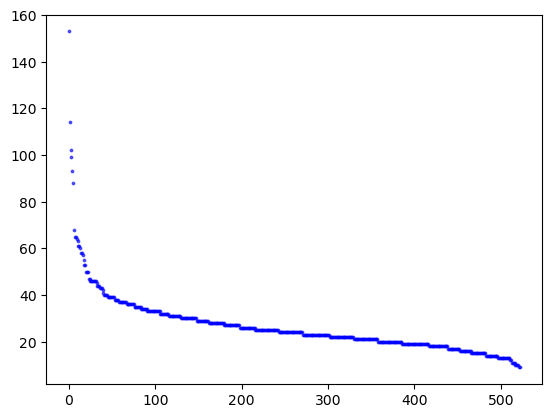

In [3]:
df = pd.read_csv('/burg/iicd/users/qc2358/Kinase_project/deg_ntc_kinases.csv')
df['Kinase'].head(100)
plt.scatter(df.index, df['IntersectionCount'], 
            s=3,  # size of points
            c='blue',  # color of points
            alpha=0.6,  # transparency
            cmap='viridis')  # color map

In [4]:
kn = KneeLocator(df.index, df['IntersectionCount'], curve='convex', direction='decreasing', S=10)
kn.knee

np.int64(91)

### 2. Generate raw and hvg files

In [5]:
gbm_crispri= an.read_h5ad('/burg/iicd/users/qc2358/Kinase_project/cds_2000.h5ad')

In [6]:
gbm_crispri_crop = gbm_crispri[
    (gbm_crispri.obs['total_sgrna_read_per_cell'] > 3) & 
    (gbm_crispri.obs['top_proportion'] > 0.3)
].copy()
gbm_crispri_crop

AnnData object with n_obs × n_vars = 114438 × 56648
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage'
    var: 'features'

In [7]:
gbm_crispri_crop.obs['gene_id']

01D_A01_RT_BC_100_Lig_BC_115      UHMK1
01D_A01_RT_BC_100_Lig_BC_116        NTC
01D_A01_RT_BC_100_Lig_BC_122        NTC
01D_A01_RT_BC_100_Lig_BC_127      TRIB1
01D_A01_RT_BC_100_Lig_BC_159      CAMK1
                                 ...   
12D_H12_RT_BC_99_Lig_BC_74         CLK2
12D_H12_RT_BC_99_Lig_BC_75         PKN2
12D_H12_RT_BC_99_Lig_BC_80         MYLK
12D_H12_RT_BC_99_Lig_BC_85      MAP3K12
12D_H12_RT_BC_99_Lig_BC_86         JAK1
Name: gene_id, Length: 114438, dtype: object

In [8]:
# Get the top kinase values
top_kinases = df['Kinase'].head(kn.knee).values
valid_gene_ids = list(top_kinases) + ['NTC']
filtered_gbm_crispri_crop = gbm_crispri_crop[gbm_crispri_crop.obs['gene_id'].isin(valid_gene_ids)]
print("Filtered gene IDs:", filtered_gbm_crispri_crop.obs['gene_id'].unique())

Filtered gene IDs: ['NTC' 'ACVR2B' 'MAPK7' 'SPEG' 'CDK6' 'CDK17' 'RPS6KA3' 'WNK2' 'CSNK1G2'
 'CDK11A' 'STRADB' 'TBK1' 'GSK3A' 'FGFR2' 'MAP3K13' 'PDIK1L' 'C9orf96'
 'SBK1' 'MAP4K1' 'CDK14' 'DAPK3' 'TTN' 'MAST4' 'STK17B' 'HIPK4' 'RIPK4'
 'TESK2' 'MARK1' 'MAPKAPK5' 'NEK9' 'ADCK3' 'MAST1' 'ANKK1' 'MET' 'IRAK1'
 'STK33' 'MAP3K14' 'DAPK2' 'PNCK' 'RIOK2' 'CDK3' 'ROCK1' 'CDK8' 'NPR2'
 'NEK8' 'SCYL2' 'WNK3' 'ERBB4' 'NEK6' 'NRBP2' 'ROCK2' 'NRBP1' 'SGK2'
 'STK38' 'BMPR1A' 'NTRK3' 'CDK12' 'MAP3K15' 'JAK1' 'MAK' 'PRPF4B' 'MAP4K3'
 'RPS6KC1' 'DSTYK' 'MAPK11' 'TYK2' 'YES1' 'PRKCZ' 'PRKACG' 'MAP3K4'
 'TRIM24' 'ICK' 'PRKD1' 'CDC42BPA' 'STRADA' 'STK40' 'BTK' 'SRPK3' 'INSRR'
 'RNASEL' 'MAP3K7' 'HIPK2' 'TESK1' 'PIM2' 'STK35' 'PIK3C2A' 'AXL' 'MASTL'
 'PDGFRA' 'PRKG2' 'BRDT' 'AURKB']


In [9]:
gene_id_counts = filtered_gbm_crispri_crop.obs['gene_id'].value_counts()
gene_id_counts

gene_id
NTC       2193
PRKCZ      489
CDK6       430
MAPK7      416
SPEG       395
          ... 
PDGFRA     113
MET        109
RIOK2       74
MAP3K7      65
AURKB       25
Name: count, Length: 92, dtype: int64

In [10]:
# Filter genes with >= 25 cells
valid_gene_ids = gene_id_counts[gene_id_counts >= 25].index
filtered_gbm_crispri_crop = filtered_gbm_crispri_crop[filtered_gbm_crispri_crop.obs['gene_id'].isin(valid_gene_ids)]
filtered_gene_id_counts = filtered_gbm_crispri_crop.obs['gene_id'].value_counts()
filtered_gene_id_counts

gene_id
NTC       2193
PRKCZ      489
CDK6       430
MAPK7      416
SPEG       395
          ... 
PDGFRA     113
MET        109
RIOK2       74
MAP3K7      65
AURKB       25
Name: count, Length: 92, dtype: int64

In [11]:
# Filter NTC cells
ntc_cells = filtered_gbm_crispri_crop[filtered_gbm_crispri_crop.obs['gene_id'] == 'NTC']

# Randomly sample 489 NTC cells (Top kinases gene count)
ntc_sampled_indices = ntc_cells.obs.sample(n=489, random_state=42).index
ntc_sampled_adata = filtered_gbm_crispri_crop[filtered_gbm_crispri_crop.obs.index.isin(ntc_sampled_indices)].copy()

# Filter out NTC cells from the original data to get non-NTC data
non_ntc_adata = filtered_gbm_crispri_crop[filtered_gbm_crispri_crop.obs['gene_id'] != 'NTC']

# Combine sampled NTC cells with non-NTC data
combined_adata = ntc_sampled_adata.concatenate(non_ntc_adata)
combined_adata

/local/ipykernel_1068420/1922479219.py:12: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = ntc_sampled_adata.concatenate(non_ntc_adata)


AnnData object with n_obs × n_vars = 19781 × 56648
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [12]:
combined_adata.obs['gene_id'].value_counts()

gene_id
NTC       489
PRKCZ     489
CDK6      430
MAPK7     416
SPEG      395
         ... 
PDGFRA    113
MET       109
RIOK2      74
MAP3K7     65
AURKB      25
Name: count, Length: 92, dtype: int64

In [13]:
def preprocess_hvg_pipeline(adata, n_top_genes=5000, min_cells=20, min_counts=100, target_sum=1e4, save_path=None):
    """
    Pipeline to process AnnData:
    1. Basic filtering
    2. Normalize and store normalized data in layers
    3. Calculate HVGs
    4. Filter to HVGs keeping raw counts in X
    
    Returns AnnData with raw counts in X and normalized data in layers
    """
    
    # Make a copy of the input data
    adata = adata.copy()
    
    print(f"Initial shape: {adata.shape}")
    
    # Basic filtering
    sc.pp.filter_cells(adata, min_counts=min_counts)
    sc.pp.filter_genes(adata, min_cells=min_cells)
    
    print(f"Shape after filtering: {adata.shape}")
    
    # Store raw counts before normalization
    raw_counts = adata.X.copy()
    
    # Normalize and log transform
    sc.pp.normalize_total(adata, target_sum=target_sum)
    sc.pp.log1p(adata)
    
    # Store normalized data in layers
    adata.layers['normalized_counts'] = adata.X.copy()
    
    # Put raw counts back in X
    adata.X = raw_counts
    
    # Calculate highly variable genes
    sc.pp.highly_variable_genes(adata, 
                              n_top_genes=n_top_genes, 
                              flavor='seurat',
                              layer='normalized_counts',  # Use normalized data for HVG calculation
                              batch_key=None)
    
    print(f"Number of highly variable genes: {sum(adata.var.highly_variable)}")
    
    # Filter to keep only HVGs
    adata_hvg = adata[:, adata.var.highly_variable].copy()
    
    print(f"Final shape: {adata_hvg.shape}")
    
    # Verify raw counts are in X
    assert 'normalized_counts' in adata_hvg.layers, "Normalized counts were not preserved"
    
    # Save if path is provided
    if save_path:
        adata_hvg.write_h5ad(save_path)
        print(f"Saved processed data to: {save_path}")
    
    return adata_hvg
    
adata_processed = preprocess_hvg_pipeline(combined_adata, 
                                          n_top_genes=5000,
                                          save_path='/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_hvg.h5ad')

Initial shape: (19781, 56648)
Shape after filtering: (19781, 20927)
Number of highly variable genes: 5000
Final shape: (19781, 5000)
Saved processed data to: /burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_hvg.h5ad


In [14]:
combined_adata_tcdg = combined_adata[:, combined_adata.var['features'].isin(T_cell_dose_gene.values)]
combined_adata_tcdg

View of AnnData object with n_obs × n_vars = 19781 × 1768
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [15]:
combined_adata_tcdg.var.rename(columns={'_index':'index'},inplace=True)
combined_adata_tcdg.raw.var.rename(columns={'_index':'index'},inplace=True) 
combined_adata_tcdg.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop.h5ad')

/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/a

### 2. Subset dataset

#### 2.1 TCDG + Kinase genes

In [16]:
import pyreadr

result = pyreadr.read_r('/burg/iicd/users/qc2358/Kinase_project/github_repos/sci-Plex-GxE/Kinome_GxE_screen/KinMap_kinase_protein_to_gene_map.rds')
data = result[None]  # RDS files contain only one object, so we use None as key
 
gene_names = data[data['gene_id'].isin(combined_adata.obs['gene_id'].unique())]['gene_short_name']
combined_genes = set(gene_names) | set(T_cell_dose_gene.values)
combined_adata_kinase_tcdg = combined_adata[:, combined_adata.var['features'].isin(combined_genes)]
combined_adata_kinase_tcdg

View of AnnData object with n_obs × n_vars = 19781 × 1850
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [17]:
combined_adata_kinase_tcdg.var.rename(columns={'_index':'index'},inplace=True)
combined_adata_kinase_tcdg.raw.var.rename(columns={'_index':'index'},inplace=True) 
combined_adata_kinase_tcdg.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_kinase_gene.h5ad')

/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/a

In [18]:
combined_adata_kinase_tcdg_untreated = combined_adata_kinase_tcdg[combined_adata_kinase_tcdg.obs['dose'] == 0]
combined_adata_kinase_tcdg_untreated.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_kinase_gene_untreated.h5ad')
combined_adata_kinase_tcdg_untreated

View of AnnData object with n_obs × n_vars = 5188 × 1850
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [19]:
import scanpy as sc
import pandas as pd
import numpy as np

def balance_anndata(adata, gene_id_column, min_cells=50, target_cells=50):
    """
    Filter genes with more than min_cells and downsample to target_cells per gene
    
    Parameters:
    -----------
    adata : AnnData
        Input AnnData object
    gene_id_column : str
        Column name in adata.obs containing gene IDs
    min_cells : int
        Minimum number of cells required per gene (default: 50)
    target_cells : int
        Number of cells to sample per gene (default: 50)
    
    Returns:
    --------
    AnnData
        Filtered and balanced AnnData object
    """
    # Get cell counts per gene
    gene_counts = adata.obs[gene_id_column].value_counts()
    
    # Filter genes with more than min_cells
    valid_genes = gene_counts[gene_counts >= min_cells].index
    
    # Create mask for valid genes
    mask = adata.obs[gene_id_column].isin(valid_genes)
    adata_filtered = adata[mask].copy()
    
    # Initialize list to store indices of sampled cells
    sampled_indices = []
    
    # Sample cells for each gene
    for gene in valid_genes:
        gene_mask = adata_filtered.obs[gene_id_column] == gene
        gene_indices = np.where(gene_mask)[0]
        
        # Sample exactly target_cells cells (with replacement if necessary)
        if len(gene_indices) >= target_cells:
            sampled = np.random.choice(gene_indices, target_cells, replace=False)
        else:
            sampled = np.random.choice(gene_indices, target_cells, replace=True)
            
        sampled_indices.extend(sampled)
    
    # Create final balanced dataset
    adata_balanced = adata_filtered[sampled_indices].copy()
    
    # Print summary statistics
    print(f"Original number of cells: {len(adata)}")
    print(f"Number of genes with >= {min_cells} cells: {len(valid_genes)}")
    print(f"Final number of cells: {len(adata_balanced)}")
    
    return adata_balanced

# Use the function
balanced_adata = balance_anndata(
    combined_adata_kinase_tcdg,
    gene_id_column='gene_id',
    min_cells=100,
    target_cells=100
)

Original number of cells: 19781
Number of genes with >= 100 cells: 89
Final number of cells: 8900


In [20]:
balanced_adata.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_kinase_gene_balanced100.h5ad')
balanced_adata

AnnData object with n_obs × n_vars = 8900 × 1850
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

#### 2.2 Untreated for tcdg adata

In [21]:
combined_adata = an.read_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop.h5ad')
combined_adata

AnnData object with n_obs × n_vars = 19781 × 1768
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [22]:
combined_adata_untreated = combined_adata[combined_adata.obs['dose'] == 0]
combined_adata_untreated.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_untreated.h5ad')
combined_adata_untreated

View of AnnData object with n_obs × n_vars = 5188 × 1768
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [23]:
gene_counts = combined_adata_untreated.obs['gene_id'].value_counts()
gene_counts.head(10)

gene_id
PRKCZ      121
MAPK7      117
NTC        117
SPEG       112
CDK6       110
TTN        102
MAST1       99
MAP3K13     88
HIPK4       84
CDK3        83
Name: count, dtype: int64

#### 2.3 Untreated for hvg adata

In [24]:
combined_adata = an.read_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_hvg.h5ad')
combined_adata

AnnData object with n_obs × n_vars = 19781 × 5000
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch', 'n_counts'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'normalized_counts'

In [25]:
combined_adata_untreated = combined_adata[combined_adata.obs['dose'] == 0]
combined_adata_untreated.write_h5ad('/burg/iicd/users/qc2358/Kinase_project/MrVi/filtered_gbm_crispri_crop_hvg_untreated.h5ad')
combined_adata_untreated

View of AnnData object with n_obs × n_vars = 5188 × 5000
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch', 'n_counts'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    layers: 'normalized_counts'

In [26]:
gene_counts = combined_adata_untreated.obs['gene_id'].value_counts()
gene_counts.head(10)

gene_id
PRKCZ      121
MAPK7      117
NTC        117
SPEG       112
CDK6       110
TTN        102
MAST1       99
MAP3K13     88
HIPK4       84
CDK3        83
Name: count, dtype: int64

In [27]:
np.median(gene_counts[gene_counts.index != 'NTC'].values)

np.float64(52.0)